## Problem 1 [EM]
- Write a 2-dimensional RNG (random number generator) for a Gaussian mixture model (GMM) pdf with 2 sub-populations. Use any function/sub-routine available in your language of choice.

<IPython.core.display.Javascript object>


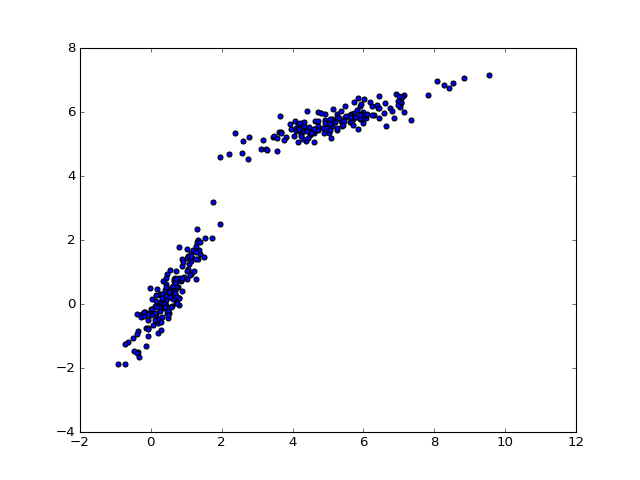

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Define the generator.
def twod2sprng(n, p, mean1, mean2, cov1, cov2):
    """
    This is a function for generating the 2-d RNG data with 2 sub-populations.
    n: number of points generated.
    p: the percent of population 1.
    mean1: the mean of the first sub-population.
    mean2: the mean of the second sub-population.
    cov1, cov2: the covarance of the first and second sub-population.
    """
    s = np.random.rand(n)
    # Generate the data for two populations
    x1, y1 = np.random.multivariate_normal(mean1, cov1, n).T
    x2, y2 = np.random.multivariate_normal(mean2, cov2, n).T
    x = (s < p)*x1 + (s >= p)*x2
    y = (s < p)*y1 + (s >= p)*y2
    return x,y

# Test the generator that we defined.
mean1 = (np.random.rand()+5,np.random.rand()+5)
mean2 = (np.random.rand(),np.random.rand())
cov1 = np.random.rand(2,2)
cov1 = np.dot(cov1,cov1.T)
cov2 = np.random.rand(2,2)
cov2 = np.dot(cov2,cov2.T)
N = 300
x, y = twod2sprng(N, 0.5, mean1, mean2, cov1, cov2)
# Visualize the data
plt.figure()
plt.scatter(x, y)
ax = plt.axes()
plt.show()

- Implement the expectation maximization (EM) algorithm for estimating the pdf parameters of 2-D GMMs from samples (Refer to the Noisy Clustering Paper linked on blackboard for the relevant update equations).
> $$
 \alpha _j(t+1) = \frac{1}{N}\sum_{i=1}^{N}p_z(j|y_i,\Theta (t))\\
 \mu _j(t+1) = \frac{\sum_{i=1}^{N} p_z(j|y_i, \Theta(t)) y_i}{\sum _{i=1}^{N} p_z (j|y_i, \Theta (t))}\\
 \Sigma _j (t+1) = \frac{\sum _{i=1}^{N} p_z (j|y_i,\Theta (t))(y_i - \mu _j(t)) (y_i - \mu _j (t))^T}{\sum _{i=1}^{N} p_z (j|y_i, \Theta (t))}
 $$

In [2]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
# Initialize the parameters, using k-mean
xy = np.array([x,y]).T
model = KMeans(n_clusters=2)
model.fit(xy)
mean1_t = model.cluster_centers_[0]
mean2_t = model.cluster_centers_[1]
cov1_t = np.ma.cov(xy.T)
cov2_t = cov1_t
p_t = np.random.rand()
# EM interation
MAXITERATION = 1000
tol = 0.001
theta = np.r_[p_t, mean1_t, mean2_t, cov1_t.reshape(-1),cov2_t.reshape(-1)]
iternum = -1
p_t_record = [p_t]
mean1_t_record = [mean1_t]
mean2_t_record = [mean2_t]
cov1_t_record = [cov1_t]
cov2_t_record = [cov2_t]
for i in range(MAXITERATION):
        # E-Step:
    w = np.array([p_t*multivariate_normal.pdf(xy, mean = mean1_t, cov = cov1_t),
                     (1-p_t)*multivariate_normal.pdf(xy, mean = mean2_t, cov = cov2_t)])
    w = w/sum(w,0)

        # M-Step:
    nml = sum(w.T)
    p_t = nml[0]/N
    mean1_t = np.r_[sum(w[0,:]*xy[:,0]), sum(w[0,:]*xy[:,1])]
    mean1_t = mean1_t/nml[0]
    mean2_t = np.r_[sum(w[1,:]*xy[:,0]), sum(w[1,:]*xy[:,1])]
    mean2_t = mean2_t/nml[1]
    c1 = np.array([w[0],w[0]]).T*(xy-mean1_t)
    c2 = np.array([w[1],w[1]]).T*(xy-mean2_t)
    cov1_t = np.dot(c1.T,xy-mean1_t)/nml[0]
    cov2_t = np.dot(c2.T,xy-mean2_t)/nml[1]
    theta_t = np.r_[p_t, mean1_t, mean2_t, cov1_t.reshape(-1),cov2_t.reshape(-1)]
    diff = sum(abs(theta_t - theta))
    theta = theta_t
    p_t_record.append(p_t)
    mean1_t_record.append(mean1_t)
    mean2_t_record.append(mean2_t)
    cov1_t_record.append(cov1_t)
    cov2_t_record.append(cov2_t)
    if diff < tol:
        iternum = i
        break
 
print 'iteration times:',i

iteration times: 5


<IPython.core.display.Javascript object>


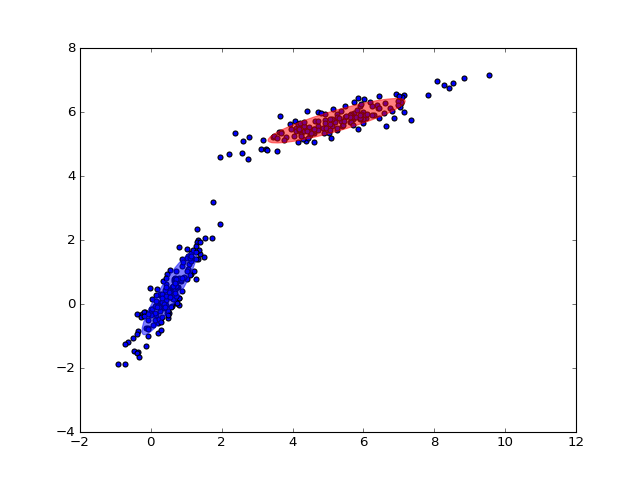

In [3]:
# Visualization of the process.
import matplotlib as mpl

if iternum < 4:
    index = np.r_[0:iternum-1]
else:
    index = np.linspace(0,iternum-1,4)
    
index = index.astype(int)
    
def add_ell_rst(mean1_t, mean2_t, cov1_t, cov2_t,ax):
    eig_vals, eig_vecs = np.linalg.eigh(cov1_t)
    unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
    angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
    angle = 180 * angle / np.pi
    eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
    ell1 = mpl.patches.Ellipse(mean1_t, eig_vals[0], eig_vals[1],
                                      180 + angle, color = 'r')

    eig_vals, eig_vecs = np.linalg.eigh(cov2_t)
    unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
    angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
    angle = 180 * angle / np.pi
    eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
    ell2 = mpl.patches.Ellipse(mean2_t, eig_vals[0], eig_vals[1],
                                      180 + angle, color = 'b')
    ell1.set_clip_box(ax.bbox)
    ell1.set_alpha(0.5)
    ell2.set_clip_box(ax.bbox)
    ell2.set_alpha(0.5)
    ax.add_artist(ell1)
    ax.add_artist(ell2)
    
plt.figure()
plt.scatter(x,y)
ax = plt.axes()
add_ell_rst(mean1_t, mean2_t, cov1_t, cov2_t,ax)
plt.show()

<IPython.core.display.Javascript object>


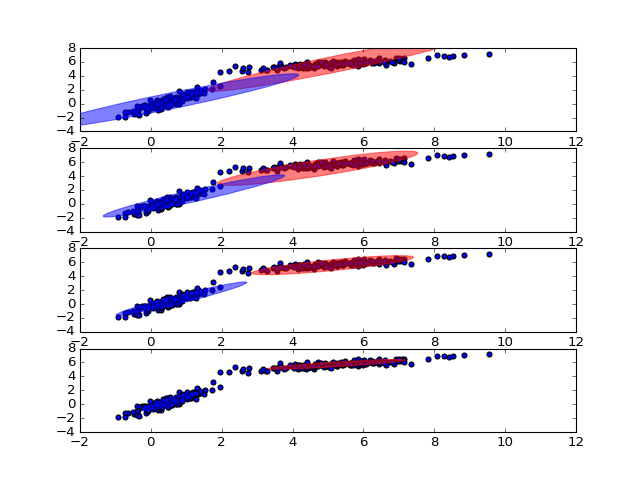

In [4]:
plt.figure()
for i in range(1,len(index)+1):
    ax = plt.subplot(len(index),1,i)
    plt.scatter(x,y)
    add_ell_rst(mean1_t_record[index[i-1]], mean2_t_record[index[i-1]], cov1_t_record[index[i-1]], cov2_t_record[index[i-1]],ax)
plt.show()

- Compare the quality and speed your GMM-EM estimation on 300 samples of different GMM distributions (e.g. spherical vs ellipsoidal covariance, close vs well-separated subpopulations).

**Speed comparison**:  
We compare the iteration times to check the speed of the EM GMM estimator for different data set.  
**Quality comparison**:  
We compare the classification error rate to check the quality of the EM GMM estimator for different data set.

In [5]:
# Define the em gmm estimator function
def my_em_2d2pgmm(xy):
    # Initialize the parameters.
    model = KMeans(n_clusters=2)
    model.fit(xy)
    mean1_t = model.cluster_centers_[0]
    mean2_t = model.cluster_centers_[1]
    cov1_t = np.ma.cov(xy.T)
    cov2_t = cov1_t
    p_t = np.random.rand()
    # EM interation
    MAXITERATION = 1000
    tol = 0.001
    theta = np.r_[p_t, mean1_t, mean2_t, cov1_t.reshape(-1),cov2_t.reshape(-1)]
    iternum = 1
    p_t_record = [p_t]
    mean1_t_record = [mean1_t]
    mean2_t_record = [mean2_t]
    cov1_t_record = [cov1_t]
    cov2_t_record = [cov2_t]
    for i in range(MAXITERATION):
            # E-Step:
        w = np.array([p_t*multivariate_normal.pdf(xy, mean = mean1_t, cov = cov1_t),
                    (1-p_t)*multivariate_normal.pdf(xy, mean = mean2_t, cov = cov2_t)])
        w = w/sum(w,0)
            # M-Step:
        nml = sum(w.T)
        p_t = nml[0]/N
        mean1_t = np.r_[sum(w[0,:]*xy[:,0]), sum(w[0,:]*xy[:,1])]
        mean1_t = mean1_t/nml[0]
        mean2_t = np.r_[sum(w[1,:]*xy[:,0]), sum(w[1,:]*xy[:,1])]
        mean2_t = mean2_t/nml[1]
        c1 = np.array([w[0],w[0]]).T*(xy-mean1_t)
        c2 = np.array([w[1],w[1]]).T*(xy-mean2_t)
        cov1_t = np.dot(c1.T,xy-mean1_t)/nml[0]
        cov2_t = np.dot(c2.T,xy-mean2_t)/nml[1]
        theta_t = np.r_[p_t, mean1_t, mean2_t, cov1_t.reshape(-1),cov2_t.reshape(-1)]
        diff = sum(abs(theta_t - theta))
        theta = theta_t
        p_t_record.append(p_t)
        mean1_t_record.append(mean1_t)
        mean2_t_record.append(mean2_t)
        cov1_t_record.append(cov1_t)
        cov2_t_record.append(cov2_t)
        if diff < tol:
            iternum = i+1
            break

    return iternum, p_t, mean1_t, mean2_t, cov1_t, cov2_t

In [6]:
# Define the new generator that will return the index of the data.
def twod2sprng_inedx(n, p, mean1, mean2, cov1, cov2):
    """
    This is a function for generating the 2-d RNG data with 2 sub-populations.
    n: number of points generated.
    p: the percent of population 1.
    mean1: the mean of the first sub-population.
    mean2: the mean of the second sub-population.
    cov1, cov2: the covarance of the first and second sub-population.
    """
    s = np.random.rand(n)
    # Generate the data for two populations
    x1, y1 = np.random.multivariate_normal(mean1, cov1, n).T
    x2, y2 = np.random.multivariate_normal(mean2, cov2, n).T
    x = (s < p)*x1 + (s >= p)*x2
    y = (s < p)*y1 + (s >= p)*y2
    return x,y, s < p

**spherical vs ellipsoidal covariance**

Generate 300 spherical separated gmm samples

In [7]:
spherial_sample_list = []
spherial_sample_index_list = []
for i in range(300):
    mean1 = (np.random.rand()+5,np.random.rand()+5)
    mean2 = (np.random.rand(),np.random.rand())
    cov1 = np.random.rand()*np.eye(2)
    cov2 = np.random.rand()*np.eye(2)
    N = 300
    x,y,index = twod2sprng_inedx(N, 0.5, mean1, mean2, cov1, cov2)
    xy = np.array([x,y]).T
    spherial_sample_list.append(xy) 
    spherial_sample_index_list.append(index)

In [8]:
# process em gmm on 300 samples
from ipywidgets import IntProgress
from IPython.display import display
p = IntProgress()
display(p)
p.value = 0
spherial_iternum_list = []
spherial_err_list = []
for i in range(300):
    p.description = 'Running'
    iternum_f, p_t, mean1_t_f, mean2_t_f, cov1_t_f, cov2_t_f = my_em_2d2pgmm(spherial_sample_list[i])
    class_index = multivariate_normal.pdf(spherial_sample_list[i], mean = mean1_t, cov = cov1_t) > multivariate_normal.pdf(spherial_sample_list[i], mean = mean2_t, cov = cov2_t)
    spherial_iternum_list.append(iternum_f)
    err_index = np.logical_xor(class_index, spherial_sample_index_list[i])
    err = min(sum(err_index), N - sum(err_index))
    spherial_err_list.append(err)
    p.value = (i+1)/3
p.description = 'Finished'

<IPython.core.display.Javascript object>


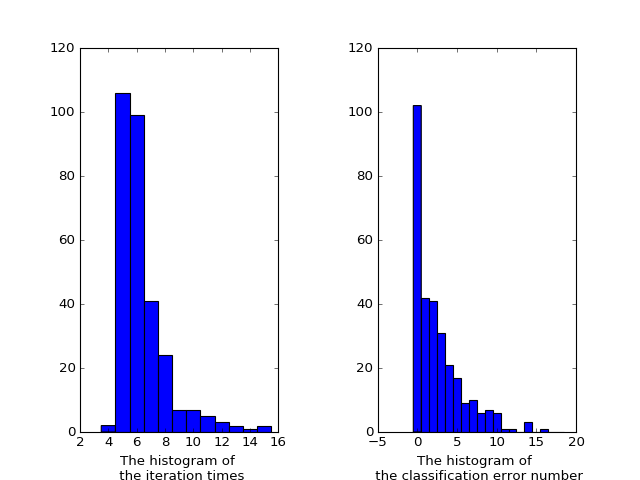

average iteration times: 6.4
average error number: 2.67


In [9]:
plt.figure()
plt.subplot(121)
plt.hist(spherial_iternum_list, bins=np.r_[min(spherial_iternum_list)-0.5:max(spherial_iternum_list)+0.5])
plt.xlabel('The histogram of \n the iteration times')
plt.subplot(122)
plt.hist(spherial_err_list, bins = np.r_[min(spherial_err_list)-0.5:max(spherial_err_list)+0.5])
plt.xlabel('The histogram of \n the classification error number')
plt.subplots_adjust(wspace = 0.5)
plt.show()
print 'average iteration times:', round(np.average(spherial_iternum_list),1)
print 'average error number:', round(np.average(spherial_err_list),2)

Generate 300 ellipsoidal gmm samples

In [10]:
ellipsoidal_sample_list = []
ellipsoidal_sample_index_list = []
for i in range(300):
    mean1 = (np.random.rand()+5,np.random.rand()+5)
    mean2 = (np.random.rand(),np.random.rand())
    
    cov1 = np.random.rand(2,2)
    cov1 = np.dot(cov1,cov1.T)
    eig_vals, eig_vecs = np.linalg.eigh(cov1)
    # Makes sure it is not spherial
    while(eig_vals[0]==eig_vals[1] or np.linalg.det(cov1)==0):
        cov1 = np.random.rand(2,2)
        cov1 = np.dot(cov1,cov1.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov1)
    
    cov2 = np.random.rand(2,2)
    cov2 = np.dot(cov2,cov2.T)
    eig_vals, eig_vecs = np.linalg.eigh(cov2)
    # Makes sure it is not spherial
    while(eig_vals[0]==eig_vals[1] or np.linalg.det(cov2)==0):
        cov2 = np.random.rand(2,2)
        cov2 = np.dot(cov2,cov2.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov2)
        
    N = 300
    x,y,index = twod2sprng_inedx(N, 0.5, mean1, mean2, cov1, cov2)
    xy = np.array([x,y]).T
    ellipsoidal_sample_list.append(xy)   
    ellipsoidal_sample_index_list.append(index) 

In [11]:
ellipsoidal_iternum_list = []
ellipsoidal_err_list = []
p.value = 0
display(p)
for i in range(300):
    iternum_f, p_t, mean1_t_f, mean2_t_f, cov1_t_f, cov2_t_f = my_em_2d2pgmm(ellipsoidal_sample_list[i])
    ellipsoidal_iternum_list.append(iternum_f)
    class_index = multivariate_normal.pdf(ellipsoidal_sample_list[i], mean = mean1_t, cov = cov1_t) > multivariate_normal.pdf(ellipsoidal_sample_list[i], mean = mean2_t, cov = cov2_t)
    p.description = 'Running'
    p.value = (i+1)/3
    err_index = np.logical_xor(class_index, ellipsoidal_sample_index_list[i])
    err = min(sum(err_index), N - sum(err_index))
    ellipsoidal_err_list.append(err)
p.description = 'Finished'    

<IPython.core.display.Javascript object>


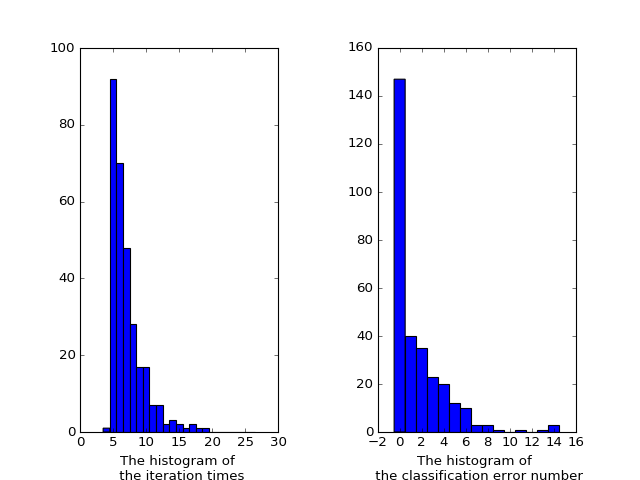

average iteration times: 7.1
average error number: 1.71


In [12]:
plt.figure()
plt.subplot(121)
plt.hist(ellipsoidal_iternum_list, bins=np.r_[min(ellipsoidal_iternum_list)-0.5:max(ellipsoidal_iternum_list)+0.5])
plt.xlabel('The histogram of \n the iteration times')
plt.subplot(122)
plt.hist(ellipsoidal_err_list, bins = np.r_[min(ellipsoidal_err_list)-0.5:max(ellipsoidal_err_list)+0.5])
plt.xlabel('The histogram of \n the classification error number')
plt.subplots_adjust(wspace = 0.5)
plt.show()
print 'average iteration times:', round(np.average(ellipsoidal_iternum_list),1)
print 'average error number:', round(np.average(ellipsoidal_err_list),2)

As we can see above, the average iteration times for spherical and ellipsoidal covariance are 6.4 and 7.1 respectively. Thus, the speed of my GMM-EM estimation on the spherical is a liitle faster than the ellipsoidal. 

**close vs well-separated subpopulations**

Generate 300 close gmm samples

In [13]:
close_sample_list = []
close_sample_index_list = []
for i in range(300):
    mean1 = (np.random.rand(),np.random.rand())
    mean2 = (np.random.rand(),np.random.rand())
    cov1 = np.random.rand(2,2)
    cov1 = np.dot(cov1,cov1.T)
    # make sure the covariance matrix is non-singular
    while np.linalg.det(cov1) == 0:
        cov1 = np.random.rand(2,2)
        cov1 = np.dot(cov1,cov1.T)
    cov2 = np.random.rand(2,2)
    cov2 = np.dot(cov2,cov2.T)
    while np.linalg.det(cov2) == 0:
        cov2 = np.random.rand(2,2)
        cov2 = np.dot(cov2,cov2.T)
    N = 300
    x,y,index = twod2sprng_inedx(N, 0.5, mean1, mean2, cov1, cov2)
    close_sample_index_list.append(index)
    xy = np.array([x,y]).T
    close_sample_list.append(xy)   

In [14]:
# Start EM GMM estimation on 300 samples.
p.value = 0
display(p)
close_iternum_list = []
close_err_list = []
for i in range(300):
    iternum_f, p_t, mean1_t_f, mean2_t_f, cov1_t_f, cov2_t_f = my_em_2d2pgmm(close_sample_list[i])
    close_iternum_list.append(iternum_f)
    class_index = multivariate_normal.pdf(close_sample_list[i], mean = mean1_t, cov = cov1_t) > multivariate_normal.pdf(close_sample_list[i], mean = mean2_t, cov = cov2_t)
    p.description = 'Running'
    p.value = (i+1)/3
    err_index = np.logical_xor(class_index, close_sample_index_list[i])
    err = min(sum(err_index), N - sum(err_index))
    close_err_list.append(err)
p.description = 'Finished'

<IPython.core.display.Javascript object>


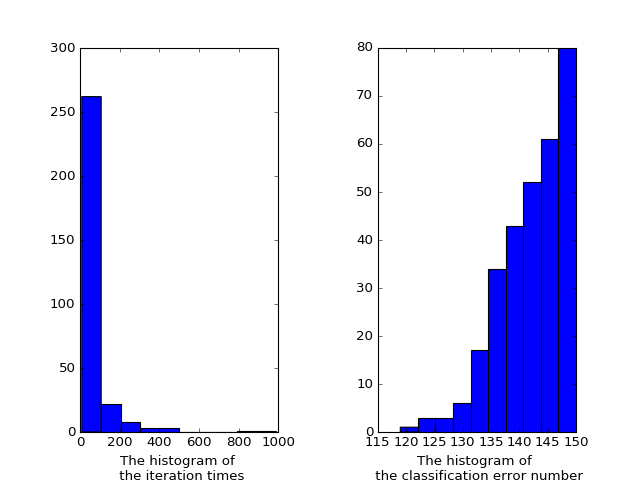

average iteration times: 60.4
average error number: 142.03


In [15]:
plt.figure()
plt.subplot(121)
plt.hist(close_iternum_list)
plt.xlabel('The histogram of \n the iteration times')
plt.subplot(122)
plt.hist(close_err_list)
plt.xlabel('The histogram of \n the classification error number')
plt.subplots_adjust(wspace = 0.5)
plt.show()
print 'average iteration times:', round(np.average(close_iternum_list),1)
print 'average error number:', round(np.average(close_err_list),2)

Generate 300 separated gmm samples

In [16]:
separated_sample_list = []
separated_sample_index_list = []
for i in range(300):
    mean1 = (np.random.rand()+5,np.random.rand()+5)
    mean2 = (np.random.rand(),np.random.rand())
    cov1 = np.random.rand(2,2)
    cov1 = np.dot(cov1,cov1.T)
    cov2 = np.random.rand(2,2)
    cov2 = np.dot(cov2,cov2.T)
    # make sure the covariance matrix is non-singular
    while np.linalg.det(cov1) == 0:
        cov1 = np.random.rand(2,2)
        cov1 = np.dot(cov1,cov1.T)
    cov2 = np.random.rand(2,2)
    cov2 = np.dot(cov2,cov2.T)
    while np.linalg.det(cov2) == 0:
        cov2 = np.random.rand(2,2)
        cov2 = np.dot(cov2,cov2.T)
    N = 300
    x,y,index = twod2sprng_inedx(N, 0.5, mean1, mean2, cov1, cov2)
    xy = np.array([x,y]).T
    separated_sample_list.append(xy)   
    separated_sample_index_list.append(index)

In [17]:
p.value = 0
display(p)
separated_iternum_list = []
separated_err_list = []
for i in range(300):
    p.description = 'Running'
    p.value = (i+1)/3
    iternum_f, p_t, mean1_t_f, mean2_t_f, cov1_t_f, cov2_t_f = my_em_2d2pgmm(separated_sample_list[i])
    class_index = multivariate_normal.pdf(
        separated_sample_list[i], mean = mean1_t, cov = cov1_t) > multivariate_normal.pdf(separated_sample_list[i], mean = mean2_t, cov = cov2_t)
    separated_iternum_list.append(iternum_f)
    err_index = np.logical_xor(class_index, separated_sample_index_list[i])
    err = min(sum(err_index), N - sum(err_index))
    separated_err_list.append(err)
p.description = 'Finished'

<IPython.core.display.Javascript object>


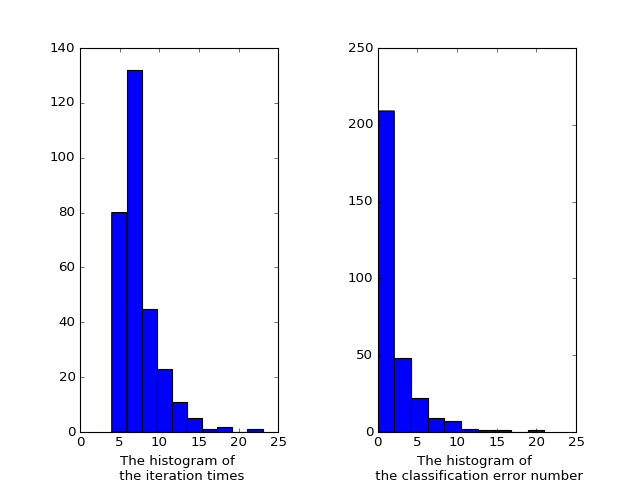

average iteration times: 7.1
average error number: 2.04


In [18]:
plt.figure()
plt.subplot(121)
plt.hist(separated_iternum_list)
plt.xlabel('The histogram of \n the iteration times')
plt.subplot(122)
plt.hist(separated_err_list)
plt.xlabel('The histogram of \n the classification error number')
plt.subplots_adjust(wspace = 0.5)
plt.show()
print 'average iteration times:', round(np.average(separated_iternum_list),1)
print 'average error number:', round(np.average(separated_err_list),2)

The average iteration times for close and separated data are 60.6 and 7.2 respectively. Therefore, we conclude that my EM gmm estimation is much faster on separated data and close data. 

**Speed comparison conclusion**:

<IPython.core.display.Javascript object>


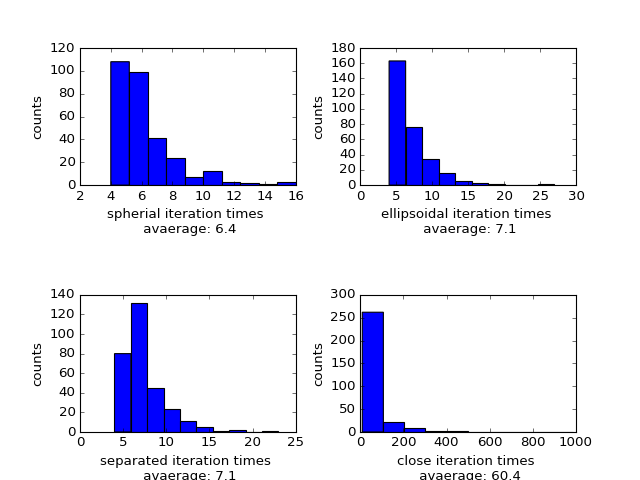

In [19]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(spherial_iternum_list)
plt.xlabel('spherial iteration times \n avaerage: '+ str(round(np.average(spherial_iternum_list),1)))
plt.ylabel('counts')
plt.subplot(2,2,2)
plt.hist(ellipsoidal_iternum_list)
plt.xlabel('ellipsoidal iteration times \n avaerage: '+ str(round(np.average(ellipsoidal_iternum_list),1)))
plt.ylabel('counts')
plt.subplot(2,2,3)
plt.hist(separated_iternum_list)
plt.xlabel('separated iteration times \n avaerage: '+ str(round(np.average(separated_iternum_list),1)))
plt.ylabel('counts')
plt.subplot(2,2,4)
plt.hist(close_iternum_list)
plt.xlabel('close iteration times \n avaerage: '+ str(round(np.average(close_iternum_list),1)))
plt.ylabel('counts')
plt.subplots_adjust(hspace = 0.8, wspace = 0.3)

As we can see above, EM GMM estimator for spherial data is much faster than ellipsoidal data. Close data set requires much more iteration times than separated data set.  

<IPython.core.display.Javascript object>


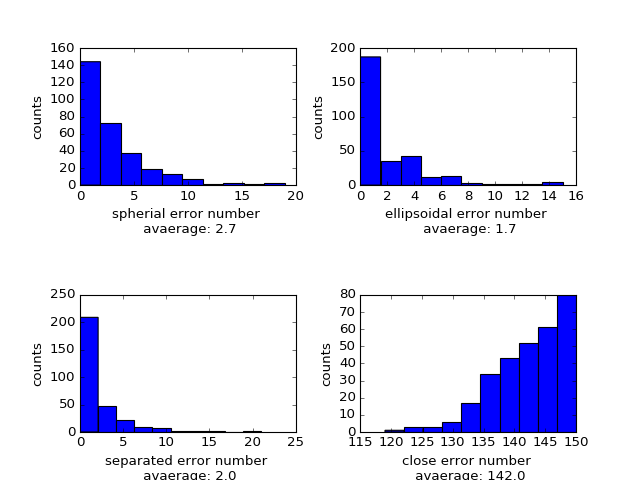

In [20]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(spherial_err_list)
plt.xlabel('spherial error number \n avaerage: '+ str(round(np.average(spherial_err_list),1)))
plt.ylabel('counts')
plt.subplot(2,2,2)
plt.hist(ellipsoidal_err_list)
plt.xlabel('ellipsoidal error number \n avaerage: '+ str(round(np.average(ellipsoidal_err_list),1)))
plt.ylabel('counts')
plt.subplot(2,2,3)
plt.hist(separated_err_list)
plt.xlabel('separated error number \n avaerage: '+ str(round(np.average(separated_err_list),1)))
plt.ylabel('counts')
plt.subplot(2,2,4)
plt.hist(close_err_list)
plt.xlabel('close error number \n avaerage: '+ str(round(np.average(close_err_list),1)))
plt.ylabel('counts')
plt.subplots_adjust(hspace = 0.8, wspace = 0.3)

In the above figure, the estimator has better quality for ellipsoidal data set than spherial. For close data set, the EM GMM estimator has a pretty high error rate. Because two population overlap together, it is naturally hard to separate them.